In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/raw/creditcard.csv')

### All Transformation

In [3]:
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
    QuantileTransformer
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA


default_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)

Time_rbf_transformer = FunctionTransformer(
    rbf_kernel,
    feature_names_out='one-to-one',
    kw_args={
        'Y':[[79000]],
        'gamma':1e-8
    }
)

q_heavy_tail_pipeline = make_pipeline(
    QuantileTransformer(output_distribution='normal'),
    StandardScaler()
)

# V2, V5, V7 with Amount
V2_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)

V5_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)

V7_amount_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=2)
)


all_transformation = ColumnTransformer(
    transformers=[
        ('Time_rbf', Time_rbf_transformer, ['Time']),
        ('heavy_tail', q_heavy_tail_pipeline, ['V1', 'V2', 'V3', 'V4', 'V5',
                                               'V6','V7', 'V8', 'V9', 'V10',
                                               'V11', 'V12', 'V14', 'V15',
                                               'V16', 'V17', 'V18', 'V19', 'V20',
                                               'V21', 'V22', 'V23', 'V24', 'V25',
                                               'V27', 'V28', 'Amount']),
        ('V2_amount', V2_amount_pipeline, ['V2', 'Amount']),
        ('V5_amount', V5_amount_pipeline, ['V5', 'Amount']),
        ('V7_amount', V7_amount_pipeline, ['V7', 'Amount'])
        
    ],
    remainder=default_pipeline,
    force_int_remainder_cols=False
)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train, test = train_test_split(df,
                               test_size=0.2,
                               stratify=df['Class'],
                               random_state=10
                               )

In [6]:
X_train, X_test = train.drop('Class', axis=1), test.drop('Class', axis=1)
y_train, y_test = train['Class'], test['Class']

## LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [9]:
lr_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('logistic_r', LogisticRegression(
            random_state=10,
            max_iter=1000,
            n_jobs=-1)
    )
])

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                               'gamma': 1e-8}], # this gamma is optimized
        'logistic_r__solver': ['saga'],
        'logistic_r__penalty': ['l1', 'l2']
    },
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                               'gamma': 1e-8}],
        'logistic_r__solver': ['sag'],
        'logistic_r__penalty': ['l2']
    },
    {
        'transformation__Time_rbf__kw_args': [{'Y': [[79000]],  
                                               'gamma': 1e-8}],
        'logistic_r__solver': ['saga'],
        'logistic_r__penalty': ['elasticnet'],
        'logistic_r__l1_ratio': [0.3, 0.5, 0.8]
    }
]

In [11]:
lr_gs = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)

In [12]:
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformation',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('Time_rbf',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function rbf_kernel at 0x0000019E48CD7560>,
                                                                                             k...
                                                                 'gamma': 1e-08}]},
                         {'logistic_r__penalty': ['l2'],
                          'logistic_r__solver': ['sag'],
                          'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                                                 'gamma': 1e-08}]},
                         {'logistic_r__l1_ratio': [0.3, 0.5, 0.8],
                          'logistic_r__penalty': ['elasticnet'],
                          'logistic_r__solver': ['saga'],
                          'transformation__Time_rbf__kw_args': [{'Y': [[79000]],
                                                                 'gamma': 1e-08}]}],
             scoring='neg_mean_absolute_error')

In [13]:
lr_gs.best_params_

{'logistic_r__penalty': 'l1',
 'logistic_r__solver': 'saga',
 'transformation__Time_rbf__kw_args': {'Y': [[79000]], 'gamma': 1e-08}}

In [14]:
MME_lr = -lr_gs.best_score_
MME_lr

0.030507581908753755

In [15]:
lr_gs.best_estimator_

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x0000019E48CD7560>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('logistic_r',
                 LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1',
                                    random_state=10, solver='saga'))])

In [16]:
pd.DataFrame(lr_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_r__penalty,param_logistic_r__solver,param_transformation__Time_rbf__kw_args,param_logistic_r__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,182.391855,45.686229,0.478657,0.036702,l1,saga,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l1', 'logistic_r__sol...",-0.030613,-0.027146,-0.033049,-0.030986,-0.030745,-0.030508,0.001900,1
4,159.323295,38.742360,0.382838,0.063757,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.5,"{'logistic_r__l1_ratio': 0.5, 'logistic_r__pen...",-0.030657,-0.027497,-0.033093,-0.031162,-0.030196,-0.030521,0.001805,2
1,162.276853,40.325040,0.463064,0.016400,l2,saga,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l2', 'logistic_r__sol...",-0.030876,-0.026729,-0.033049,-0.031227,-0.030832,-0.030543,0.002073,3
3,172.978360,37.952233,0.426411,0.045362,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.3,"{'logistic_r__l1_ratio': 0.3, 'logistic_r__pen...",-0.030986,-0.027299,-0.032961,-0.031096,-0.030657,-0.030600,0.001837,4
2,87.560466,22.272178,0.433196,0.012039,l2,sag,"{'Y': [[79000]], 'gamma': 1e-08}",NaN,"{'logistic_r__penalty': 'l2', 'logistic_r__sol...",-0.031030,-0.027497,-0.032895,-0.031447,-0.030262,-0.030626,0.001784,5
5,142.138535,26.318033,0.351490,0.124626,elasticnet,saga,"{'Y': [[79000]], 'gamma': 1e-08}",0.8,"{'logistic_r__l1_ratio': 0.8, 'logistic_r__pen...",-0.030832,-0.027080,-0.032807,-0.031644,-0.030986,-0.030670,0.001925,6


In [17]:
# fitting params into model
lr_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('logistic_r', LogisticRegression(
            penalty='elasticnet', # elasticnet showed better performance in terms of runtime
            l1_ratio=0.8,
            solver='saga',
            random_state=10,
            max_iter=1000,
            n_jobs=-1)
    )
])

## Evaluation for LogisticRegression

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [19]:
y_scores_lr = cross_val_predict(
    lr_pipeline,
    X_train,
    y_train,
    cv=5,
    method='decision_function',
    n_jobs=-1
)

In [20]:
y_scores_lr.shape

(227845,)

In [21]:
# y_scores_fraud_lr = y_scores_lr[:, 1]  # probability of being a fraud

# if probability is over 0.5 return 1, else return 0
y_pred_lr = (y_scores_lr > 0.5).astype(int)

In [22]:
precision_score(y_train, y_pred_lr)

0.07256745707277187

In [23]:
recall_score(y_train, y_pred_lr)

0.9010152284263959

In [24]:
f1_score(y_train, y_pred_lr)

0.1343170639424896

In [25]:
from sklearn.metrics import precision_recall_curve

In [26]:
precision, recall, thresholds = precision_recall_curve(y_true=y_train, y_score=y_scores_lr)

In [27]:
thresholds.shape

(227153,)

In [28]:
recall.shape

(227154,)

In [29]:
precision.shape

(227154,)

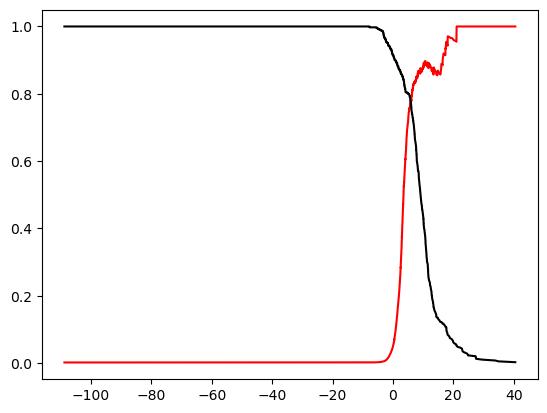

In [30]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
plt.show()

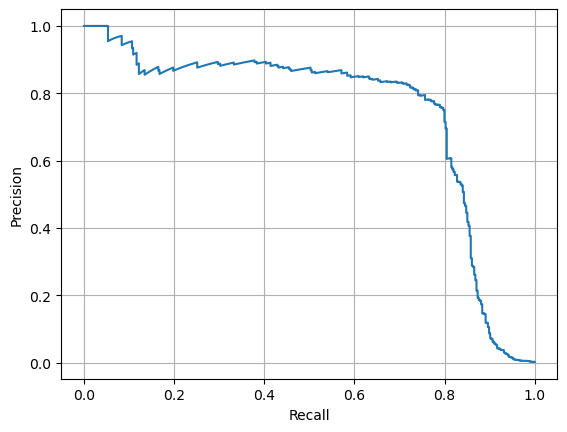

In [31]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

In [32]:
# set threshold based on recall and precision

In [33]:
threshold_75_precision = thresholds[(precision >= 0.75).argmax()]

In [34]:
threshold_75_precision

5.342830925946151

In [35]:
y_pred_75_precision = (y_scores_lr >= threshold_75_precision)

In [36]:
y_pred_75_precision

array([False, False, False, ..., False, False, False])

In [37]:
precision_score(y_train, y_pred_75_precision)

0.75

In [38]:
recall_score(y_train, y_pred_75_precision)

0.799492385786802

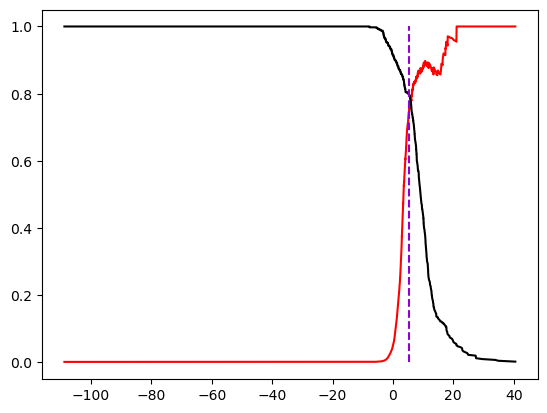

In [39]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')

ax.plot([threshold_75_precision, threshold_75_precision], [0,1], color='darkviolet', ls='--')
plt.show()

In [40]:
from sklearn.metrics import roc_curve

In [41]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_lr)

Text(0, 0.5, 'TP Ratio')

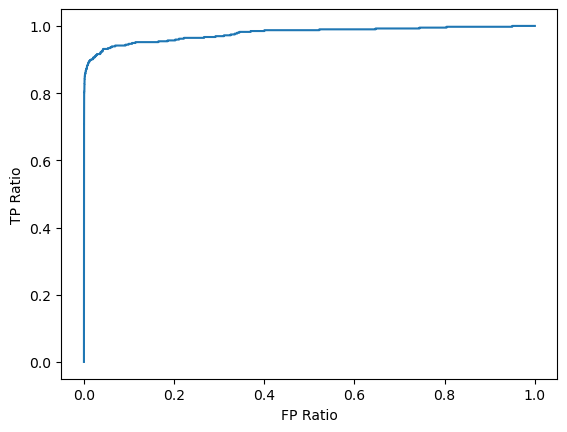

In [42]:
plt.plot(fpr, tpr)
plt.xlabel("FP Ratio")
plt.ylabel("TP Ratio")

In [43]:
# roc_auc_score lr

In [44]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores_lr)

0.9774783867656038

## LGBMClassifier

In [45]:
# !pip install lightgbm

In [46]:
import lightgbm
lightgbm.__version__

'4.6.0'

SMOTE

In [47]:
# !pip install imbalanced-learn

In [48]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# smote = SMOTE(random_state=10)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [49]:
from lightgbm import LGBMClassifier

In [50]:
lgbm_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('lgbm', LGBMClassifier(
        random_state=10,
        n_jobs=-1,
        # verbose=-1,
    ))
])


In [51]:
lgbm_param_grid = [
    {
        'lgbm__boosting_type':['gbdt'],
        'lgbm__learning_rate':[0.05, 0.1, 0.2],
        'lgbm__num_leaves': [60, 70, 75],
        'lgbm__subsample':[0.5, 0.7, 1],   # subsample should be <= 1
        'lgbm__data_sample_strategy':['goss']
    },
]

In [52]:
lgbm_gs = GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid=lgbm_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

In [53]:
lgbm_gs.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('transformation',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('Time_rbf',
                                                                         FunctionTransformer(feature_names_out='one-to-one',
                                                                                             func=<function rbf_kernel at 0...
                                                                                          PCA(n_components=2))]),
                                                                         ['V7',
                                                                          'Amount'])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('lgbm',
                                        LGBMClassifier(n_jobs=-1,
                                                       random_state=10))]),
             n_jobs=-1,
             param_grid=[{'lgbm__boosting_type': ['gbdt'],
                          'lgbm__data_sample_strategy': ['goss'],
                          'lgbm__learning_rate': [0.05, 0.1, 0.2],
                          'lgbm__num_leaves': [60, 70, 75],
                          'lgbm__subsample': [0.5, 0.7, 1]}],
             scoring='neg_mean_absolute_error')

In [54]:
lgbm_gs.best_params_

{'lgbm__boosting_type': 'gbdt',
 'lgbm__data_sample_strategy': 'goss',
 'lgbm__learning_rate': 0.2,
 'lgbm__num_leaves': 70,
 'lgbm__subsample': 1}

In [55]:
MME_lgbm = -lgbm_gs.best_score_
MME_lgbm

0.0004915622462639075

In [56]:
lgbm_gs.best_estimator_

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x0000019E48CD7560>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('lgbm',
                 LGBMClassifier(data_sample_strategy='goss', learning_rate=0.2,
                                n_jobs=-1, num_leaves=70, random_state=10,
                                subsample=1))])

In [57]:
lgbm_gs.n_splits_

5

In [58]:
pd.DataFrame(lgbm_gs.cv_results_).sort_values(by='mean_test_score', ascending=False)[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lgbm__boosting_type,param_lgbm__data_sample_strategy,param_lgbm__learning_rate,param_lgbm__num_leaves,param_lgbm__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,68.256062,9.310336,0.970872,0.068445,gbdt,goss,0.2,70,1.0,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000505,-0.000549,-0.000439,-0.000505,-0.000461,-0.000492,0.000038,1
25,54.602060,3.315195,0.795998,0.184461,gbdt,goss,0.2,75,0.7,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000527,-0.000593,-0.000351,-0.000593,-0.000483,-0.000509,0.000089,2
18,62.654140,8.242273,0.958544,0.051319,gbdt,goss,0.2,60,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000527,-0.000593,-0.000417,-0.000527,-0.000505,-0.000514,0.000057,3
22,54.155055,8.339699,1.008033,0.127943,gbdt,goss,0.2,70,0.7,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000614,-0.000549,-0.000351,-0.000527,-0.000549,-0.000518,0.000088,4
24,60.350880,7.720881,0.951222,0.028898,gbdt,goss,0.2,75,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000571,-0.000593,-0.000395,-0.000593,-0.000461,-0.000522,0.000080,5
21,53.836279,11.530439,1.270827,0.483563,gbdt,goss,0.2,70,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000571,-0.000571,-0.000373,-0.000571,-0.000571,-0.000531,0.000079,6
15,60.364026,14.152164,1.205827,0.217392,gbdt,goss,0.1,75,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000593,-0.000636,-0.000527,-0.000614,-0.000593,-0.000593,0.000037,7
14,68.837692,8.939048,1.004719,0.055858,gbdt,goss,0.1,70,1.0,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000636,-0.000680,-0.000549,-0.000549,-0.000571,-0.000597,0.000053,8
17,56.325109,8.590982,1.038192,0.061875,gbdt,goss,0.1,75,1.0,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000614,-0.000658,-0.000571,-0.000658,-0.000571,-0.000614,0.000039,9
12,71.956381,9.065562,1.052233,0.049109,gbdt,goss,0.1,70,0.5,"{'lgbm__boosting_type': 'gbdt', 'lgbm__data_sa...",-0.000724,-0.000636,-0.000549,-0.000571,-0.000593,-0.000614,0.000062,9


### Evaluation for LGBM

In [59]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

In [60]:
lgbm_pipeline = imbPipeline([
    ('transformation', all_transformation),
    ('smote', SMOTE(random_state=10)),
    ('lgbm', LGBMClassifier(
        boosting_type='gbdt',
        learning_rate=0.2,
        num_leaves=70,
        subsample=0.5,
        data_sample_strategy='goss',
        random_state=10,
        n_jobs=-1,
        verbose=-1
    ))
])

In [61]:
y_scores_lgbm = cross_val_predict(
    lgbm_pipeline,
    X_train,
    y_train,
    cv=5,
    method='predict_proba',
    n_jobs=-1
)

In [62]:
y_scores_lgbm

array([[9.99999948e-01, 5.21484622e-08],
       [9.99999992e-01, 7.96171732e-09],
       [9.99999979e-01, 2.07081437e-08],
       ...,
       [9.99999908e-01, 9.21037754e-08],
       [9.99999982e-01, 1.83675244e-08],
       [9.99999696e-01, 3.04293023e-07]])

In [63]:
y_scores_lgbm_fraud = y_scores_lgbm[:, 1]  # probability of being a fraud
y_scores_lgbm_fraud

array([5.21484622e-08, 7.96171732e-09, 2.07081437e-08, ...,
       9.21037754e-08, 1.83675244e-08, 3.04293023e-07])

In [64]:
from sklearn.metrics import precision_recall_curve

In [65]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_train,
    y_score=y_scores_lgbm_fraud,
)

In [66]:
precision.shape

(225627,)

In [67]:
recall.shape

(225627,)

In [68]:
thresholds.shape

(225626,)

In [69]:
thresholds.max()

0.9999999942104696

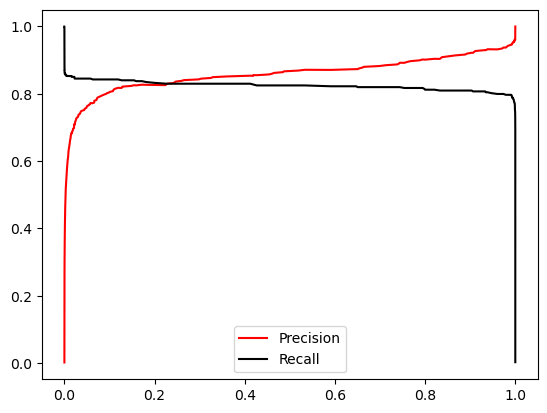

In [70]:
fig, ax = plt.subplots()

ax.plot(thresholds, precision[:-1], color='r', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
ax.legend()
plt.show()

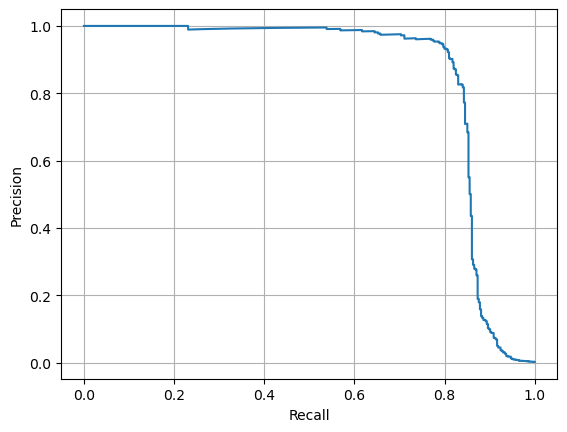

In [71]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [72]:
# changing threshold

In [73]:
threshold_90_precision = thresholds[(precision >= 0.90).argmax()]
threshold_90_precision

0.7945137194363832

In [74]:
y_pred_90_precision = (y_scores_lgbm_fraud >= threshold_90_precision)
y_pred_90_precision

array([False, False, False, ..., False, False, False])

In [75]:
precision_score(y_train, y_pred_90_precision)

0.9019607843137255

In [76]:
recall_score(y_train, y_pred_90_precision)

0.817258883248731

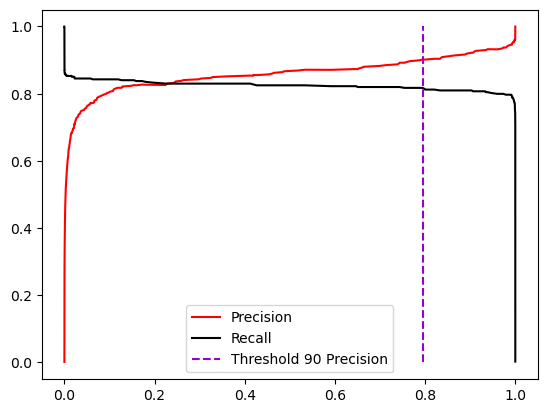

In [77]:
fig, ax = plt.subplots()

ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')

ax.plot([threshold_90_precision, threshold_90_precision], [0,1],
        color='darkviolet', ls='--', label='Threshold 90 Precision')
ax.legend()
plt.show()

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score

**F1 score**

In [79]:
# if probability is over 0.5 return 1, else return 0
y_pred = (y_scores_lgbm[:, 1] > 0.5).astype(int)

In [80]:
precision_score(y_train, y_pred)

0.8689839572192514

In [81]:
recall_score(y_train, y_pred)

0.8248730964467005

In [82]:
f1_score(y_train, y_pred)

0.8463541666666666

**ROC Curve**

In [83]:
from sklearn.metrics import roc_curve

In [84]:
fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_scores_lgbm_fraud)

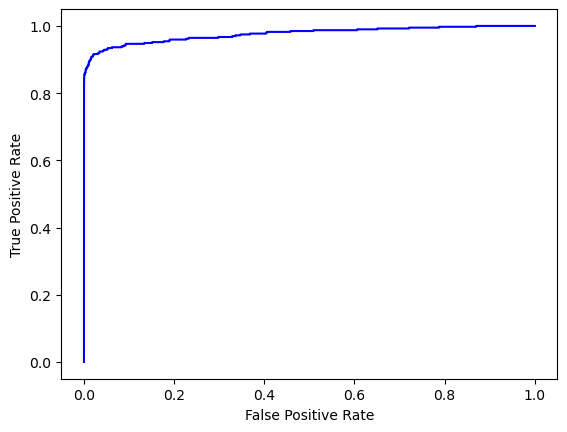

In [85]:
plt.plot(fpr, tpr, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# working on test dataset

### LGBM

In [86]:
lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x0000019E48CD7560>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('lgbm',
                 LGBMClassifier(data_sample_strategy='goss', learning_rate=0.2,
                                n_jobs=-1, num_leaves=70, random_state=10,
                                subsample=0.5, verbose=-1))])

In [87]:
test_predit_lgbm = lgbm_pipeline.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [88]:
# f1 score on test data with LGBM

In [89]:
f1_score(y_test, test_predit_lgbm)

0.8279569892473119

In [90]:
y_score_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [91]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_lgbm)

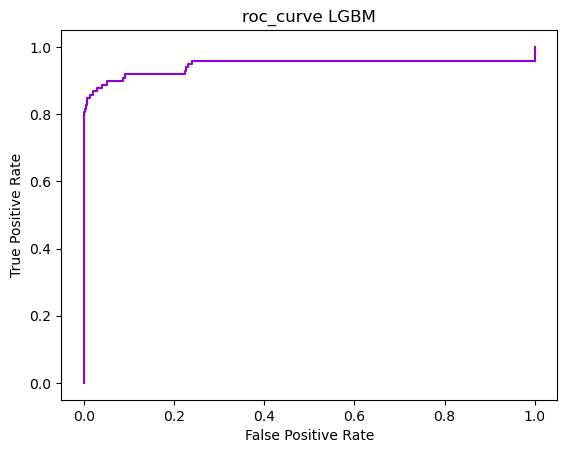

In [92]:
plt.plot(fpr, tpr, color='darkviolet')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_curve LGBM')
plt.show()

### roc_auc_score

In [93]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_score_lgbm)
auc

0.9462263345124206

In [94]:
y_score_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [95]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_test,
    y_score=y_score_lgbm,
)

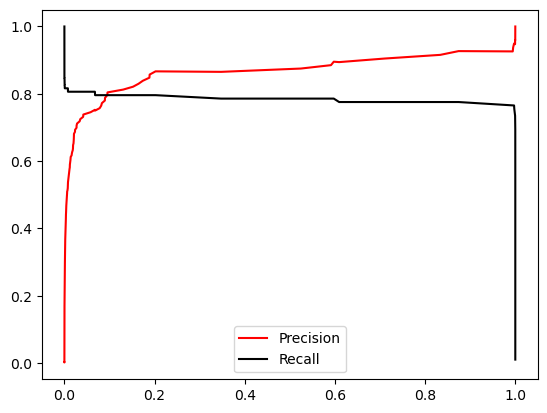

In [96]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
ax.legend()

plt.show()

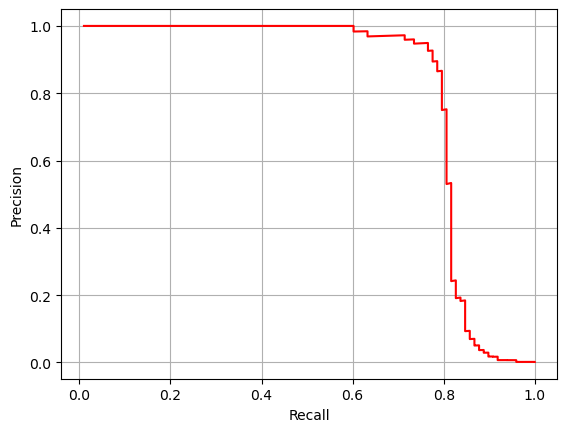

In [97]:
fig, ax = plt.subplots()
ax.plot(recall[:-1], precision[:-1], color='red',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

plt.show()

### Logistic Regression

In [98]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('Time_rbf',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function rbf_kernel at 0x0000019E48CD7560>,
                                                                      kw_args={'Y': [[79000]],
                                                                               'gamma...
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V5', 'Amount']),
                                                 ('V7_amount',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['V7', 'Amount'])])),
                ('smote', SMOTE(random_state=10)),
                ('logistic_r',
                 LogisticRegression(l1_ratio=0.8, max_iter=1000, n_jobs=-1,
                                    penalty='elasticnet', random_state=10,
                                    solver='saga'))])

In [99]:
test_predict_lr = lr_pipeline.predict(X_test)

In [100]:
# f1 score

In [101]:
f1_score(y_test, test_predict_lr)

0.09414225941422594

In [102]:
y_score_lr = lr_pipeline.decision_function(X_test)

In [103]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_lr)

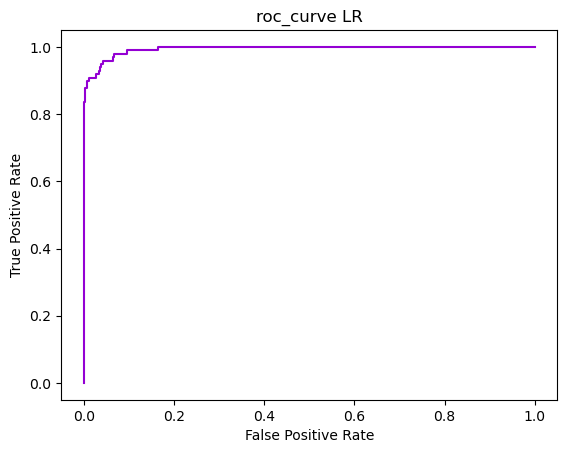

In [104]:
plt.plot(fpr, tpr, color='darkviolet')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_curve LR')
plt.show()

### roc_auc_score

In [105]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_score_lr)
auc

0.9937421402156811

In [106]:
precision, recall, thresholds = precision_recall_curve(
    y_true=y_test,
    y_score=y_score_lr,
)

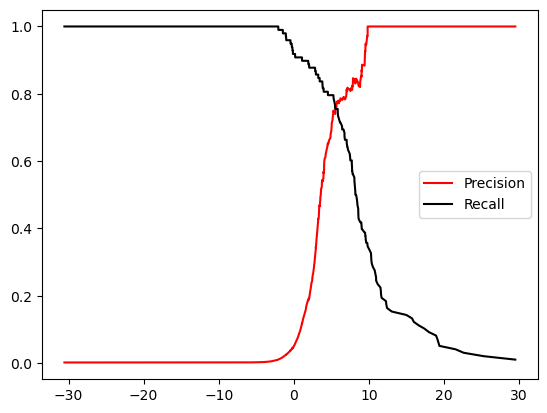

In [107]:
fig, ax = plt.subplots()
ax.plot(thresholds, precision[:-1], color='red', label='Precision')
ax.plot(thresholds, recall[:-1], color='black', label='Recall')
ax.legend()

plt.show()

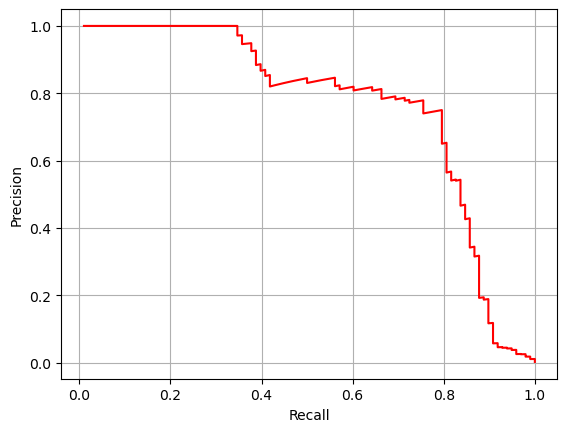

In [108]:
fig, ax = plt.subplots()
ax.plot(recall[:-1], precision[:-1], color='red',)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

plt.show()

# Comparison

In [109]:
# test

In [110]:
data_test = {
    'Model':['Logistic Regression', 'LGBM'],
    'Precision_Score':[precision_score(y_test, test_predict_lr), precision_score(y_test, test_predit_lgbm)],
    'Recall_Score':[recall_score(y_test, test_predict_lr), precision_score(y_test, test_predit_lgbm)],
    'F1_Score':[f1_score(y_test, test_predict_lr), f1_score(y_test, test_predit_lgbm)],
    'roc_auc_score':[roc_auc_score(y_test, y_score_lr), roc_auc_score(y_test, y_score_lgbm)],
}

In [111]:
diff_test = pd.DataFrame(data_test)
diff_test

,Model,Precision_Score,Recall_Score,F1_Score,roc_auc_score
0,Logistic Regression,0.049614,0.918367,0.094142,0.993742
1,LGBM,0.875000,0.875000,0.827957,0.946226


In [112]:
# train

In [113]:
data_train = {
    'Model':['Logistic Regression', 'LGBM'],
    'Precision_Score':[precision_score(y_train, y_pred_lr), precision_score(y_train, y_pred)],
    'Recall_Score':[recall_score(y_train, y_pred_lr), precision_score(y_train, y_pred)],
    'F1_Score':[f1_score(y_train, y_pred_lr), f1_score(y_train, y_pred)],
    'roc_auc_score':[roc_auc_score(y_train, y_scores_lr), roc_auc_score(y_train, y_scores_lgbm_fraud)],
}

In [114]:
diff_train = pd.DataFrame(data_train)
diff_train

,Model,Precision_Score,Recall_Score,F1_Score,roc_auc_score
0,Logistic Regression,0.072567,0.901015,0.134317,0.977478
1,LGBM,0.868984,0.868984,0.846354,0.976254


In [115]:
# optimized threshold on train

In [116]:
data_opt_train = {
    'Model':['Logistic Regression', 'LGBM'],
    'Precision_Score':[precision_score(y_train, y_pred_75_precision), precision_score(y_train, y_pred_90_precision)],
    'Recall_Score':[recall_score(y_train, y_pred_75_precision), precision_score(y_train, y_pred_90_precision)],
    'F1_Score':[f1_score(y_train, y_pred_75_precision), f1_score(y_train, y_pred_90_precision)],
}

In [117]:
diff_opt = pd.DataFrame(data_opt_train)
diff_opt.set_index('Model', inplace=True)
diff_opt

,Precision_Score,Recall_Score,F1_Score
Model,,,
Logistic Regression,0.750000,0.799492,0.773956
LGBM,0.901961,0.901961,0.857523


Optimum Treshold is better, because there is a balance in precision and recall

In [118]:
total_mean = (diff_train.iloc[:, 1:] + (diff_test.iloc[:, 1:])) / 2
total_mean['Model'] = ['Logistic Regression', 'LGBM']
total_mean.set_index('Model', inplace=True)
total_mean

,Precision_Score,Recall_Score,F1_Score,roc_auc_score
Model,,,,
Logistic Regression,0.061091,0.909691,0.114230,0.98561
LGBM,0.871992,0.871992,0.837156,0.96124
